<a href="https://colab.research.google.com/github/akshay8867/Refined_Code/blob/master/Combined_Full_Text_Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Available for 
- Water Resources Research 
- Water Resources Management
- Sustainable Water Resources Management
- Canadian Water Resources Journal
- Journal of Water Resources Planning and Management
- Water Environment Research
- Integrated Environmental Assessment and Management

# PDF Links not available for
- Environmental Impact Assessment Review 
- Journal of Environmental Management
- Water Research
- Advances in Water Resources

# Results not available from the elsapy api(Scopus API)
- Environmental modelling and software
- Journal of hydrology
- Annual Review of Environment and Resources 







In [ ]:
!pip install --upgrade gensim
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()


!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

!pip install pyLDAvis
!pip install nltk
!pip install seaborn 
import seaborn as sns
import gensim
from collections import defaultdict
gensim.__version__

In [ ]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)     

/content/drive
Mounted at /content/drive


In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import os
import pickle

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel,TfidfModel
from gensim.corpora import Dictionary

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


import nltk
nltk.download('stopwords')

from sklearn.model_selection import GridSearchCV

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pickle
lemma_path=r'/content/drive/MyDrive/Lemmatised_Text'
lemma_text=[]
for root,dir,files in os.walk(lemma_path,topdown=True):
  for file in files[:1]:
    print(os.path.join(root,file))
    with open(os.path.join(root,file),'rb') as f:
      dct=pickle.load(f)
      lemma_text=lemma_text + list(dct.values())[0]
      print(len(lemma_text))

id2word=Dictionary()
corpus=[id2word.doc2bow(doc,allow_update=True) for doc in lemma_text ]
tfidf=TfidfModel(corpus,id2word,normalize=True)


/content/drive/MyDrive/Lemmatised_Text/data_lemmatized_full_text_df1000.pkl.pkl
1000


In [ ]:
def cal_perc(a,perc):
  return np.percentile(a,perc)

import numpy as np
a=[]
for doc in corpus:
  for id, value in tfidf[doc]:
    a.append(value)


In [ ]:
import concurrent.futures
def tf_idf_filteration1(link):

    global tfidf
    global id2word
    global corpus
    words_omitted = []
    finally_omitted_words = []
    word_list = defaultdict(int)

    bow = link[1]
    # print("Original length:{}".format(str(len(bow))))
    low_value_words = []  # reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow] if value>link[2]]
    # print("tfidf len:{}".format(str(len(tfidf_ids))))
    new_bow = [b for b in bow if b[0] in tfidf_ids ]
    # print("New length:{}".format(str(len(new_bow))))

    corpus[link[0]] = new_bow

    # print("New length reflected in corpus:{}".format(str(len(corpus[link[0]]))))
    return 1

In [ ]:
def low_value_filter(perc,corpus):
  global a
  low_value=cal_perc(a,perc)
  
  corpus=[(k,doc,low_value) for k,doc in enumerate(corpus)]
  print(corpus[0])
  i=0
  while i < len(corpus):
      # print(i)
      if i +100< len(corpus):
          # print("hello")
          with concurrent.futures.ThreadPoolExecutor(100) as executor:
              results = executor.map(tf_idf_filteration1, corpus[i:i + 100])
          i=i+100
      else:
        # print("Entered else block")
        with concurrent.futures.ThreadPoolExecutor(100) as executor:
              results = executor.map(tf_idf_filteration1, corpus[i:])
        i=i+100
        break
  


In [ ]:
import time
import shutil

def topic_model(num_topics,corpus,id2word,lemma_text,perc,mallet_path):
  try:
  
    t1=time.perf_counter()
    print("Original Length:{}".format(str(len(corpus[0]))))
    low_value_filter(perc,corpus)
    print("New Length:{}".format(str(len(corpus[0]))))
    print("Corpus Updated")
    model = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                  corpus=corpus, 
                                                  num_topics=num_topics, 
                                                  id2word=id2word,
                                                  random_seed=10,
                                                  optimize_interval=100,
                                                  iterations=1000)

    print("Model has been created")
    parent_dir=r'/content/drive/MyDrive/Full_text_topic'
    child_dir="Perc{}Topics{}".format(str(perc),str(num_topics))
    if os.path.exists(os.path.join(parent_dir,child_dir)):
      shutil.rmtree(os.path.join(parent_dir,child_dir))
      print("Directory has been deleted")

    if not os.path.exists(os.path.join(parent_dir,child_dir)):
        os.makedirs(os.path.join(parent_dir,child_dir))
        print("Directory has been created")

    final_path=os.path.join(parent_dir,child_dir)
    with open(os.path.join(final_path,"{}.pkl".format(str(num_topics))),'wb') as f :
      pickle.dump(model,f)

    with open(model.ftopickeys(),'r') as f:
      with open(os.path.join(final_path,"{}topickeys.txt".format(str(num_topics))),'w') as m:
        m.write(f.read())
    cv_val=['c_npmi','c_v','c_uci','u_mass']
    coherence_values=[] 

    with open(os.path.join(final_path,"{}coherenceval.txt".format(str(num_topics))),'w') as m:
      for coherence in cv_val:
        print(coherence)
        coherencemodel = CoherenceModel(model=model, texts=lemma_text, dictionary=id2word, coherence=coherence)
        coherence_values.append(coherencemodel.get_coherence())
        m.write("{}:{}\n".format(coherence,str(coherencemodel.get_coherence())))

    t2=time.perf_counter()
    print("Ended in {} minutes".format(str((t2-t1)/60)))
    return 1
  except Exception as e:
    print("Exception occured:{}".format(e))
    return 0

# **Code block to run experiments**
- perc_values=[85,90,95]
- topicno=[10,15,20,25]


In [ ]:
perc_values=[75,95]
topicno=[10]
result_list=[]
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
for perc in perc_values:
  print(perc)
  for num_topics in topicno:
    
    mallet_path = '/content/mallet-2.0.8/bin/mallet'
    corpus=[id2word.doc2bow(doc,allow_update=True) for doc in lemma_text ]
    result_list.append(topic_model(num_topics,corpus,id2word,lemma_text,perc,mallet_path))
    print("{} completed".format(str(num_topics)))


In [ ]:
topic_path=r'/content/drive/MyDrive/Full_text_topic'
dir_components={}


for root,dirs,files in os.walk(topic_path,topdown=True):
  for dir in dirs:
    file_components=[]
    if "Perc" in dir:
      for root1,dir1,files1 in os.walk(os.path.join(root,dir)):
        print(root1.split("/")[-1])
        for file in files1:
          print(os.path.join(root1,file))
          file_components.append(os.path.join(root1,file))
      dir_components[root1.split("/")[-1]]=file_components

        # print()

Perc85Topics10
/content/drive/MyDrive/Full_text_topic/Perc85Topics10/10.pkl
/content/drive/MyDrive/Full_text_topic/Perc85Topics10/10topickeys.txt
/content/drive/MyDrive/Full_text_topic/Perc85Topics10/10coherenceval.txt
Perc85Topics15
/content/drive/MyDrive/Full_text_topic/Perc85Topics15/15.pkl
/content/drive/MyDrive/Full_text_topic/Perc85Topics15/15topickeys.txt
/content/drive/MyDrive/Full_text_topic/Perc85Topics15/15coherenceval.txt
Perc85Topics20
/content/drive/MyDrive/Full_text_topic/Perc85Topics20/20.pkl
/content/drive/MyDrive/Full_text_topic/Perc85Topics20/20topickeys.txt
/content/drive/MyDrive/Full_text_topic/Perc85Topics20/20coherenceval.txt
Perc85Topics25
/content/drive/MyDrive/Full_text_topic/Perc85Topics25/25.pkl
/content/drive/MyDrive/Full_text_topic/Perc85Topics25/25topickeys.txt
/content/drive/MyDrive/Full_text_topic/Perc85Topics25/25coherenceval.txt
Perc90Topics10
/content/drive/MyDrive/Full_text_topic/Perc90Topics10/10.pkl
/content/drive/MyDrive/Full_text_topic/Perc90Top

In [ ]:
coherence_df=pd.DataFrame(columns=['Combination','Coherence Type','Coherence Value'])

for k,v in dir_components.items():
  print(k)
  with open(v[-1],'r') as f:
    for line in f.readlines():
      print(line.split(":")[0])
      print(line.split(":")[1][:-1])
      df_=pd.DataFrame([{'Combination':k,'Coherence Type':line.split(":")[0]
                         ,'Coherence Value':float(line.split(":")[1][:-1])}])
      coherence_df=pd.concat([coherence_df,df_])
coherence_df.reset_index(drop=True,inplace=True)
coherence_df      

Perc85Topics10
c_npmi
0.06560897065604875
c_v
0.5620341952661617
c_uci
0.5362399943349272
u_mass
-0.9470556154025326
Perc85Topics15
c_npmi
0.0668691918797484
c_v
0.5634572865894328
c_uci
0.5675227545403314
u_mass
-0.9589737802904278
Perc85Topics20
c_npmi
0.06854457119382806
c_v
0.5610632988763722
c_uci
0.6037133784237277
u_mass
-1.0477956818566876
Perc85Topics25
c_npmi
0.073827230428606
c_v
0.5798671549646592
c_uci
0.6684332293644583
u_mass
-1.1089972771742376
Perc90Topics10
c_npmi
0.024246494553987308
c_v
0.3962455925484992
c_uci
0.17446768750449762
u_mass
-0.44907838322306953
Perc90Topics15
c_npmi
0.024588925112723037
c_v
0.3998168289829776
c_uci
0.18300789905148515
u_mass
-0.456276308104757
Perc90Topics20
c_npmi
0.0774765109890148
c_v
0.5888803708511676
c_uci
0.6933697990260848
u_mass
-1.1324503171043314
Perc90Topics25
c_npmi
0.07235917339634672
c_v
0.5705150002568086
c_uci
0.6557449476427224
u_mass
-1.1971698494628058
Perc95Topics20
c_npmi
0.06946548932206574
c_v
0.5654504858793172

,Combination,Coherence Type,Coherence Value
0,Perc85Topics10,c_npmi,0.065609
1,Perc85Topics10,c_v,0.562034
2,Perc85Topics10,c_uci,0.536240
3,Perc85Topics10,u_mass,-0.947056
4,Perc85Topics15,c_npmi,0.066869
5,Perc85Topics15,c_v,0.563457
6,Perc85Topics15,c_uci,0.567523
7,Perc85Topics15,u_mass,-0.958974
8,Perc85Topics20,c_npmi,0.068545
9,Perc85Topics20,c_v,0.561063


# **Comparing the coherence of different models**

In [ ]:
list(pd.unique(coherence_df['Coherence Type']))

['c_npmi', 'c_v', 'c_uci', 'u_mass']

# **Plotting for C_V**

,index,Combination,Coherence Type,Coherence Value
6,6,Perc90Topics20,c_v,0.58888


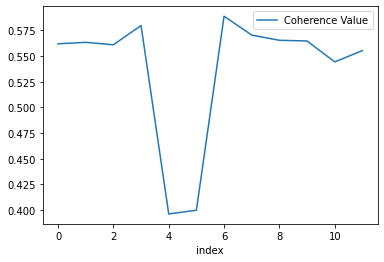

In [ ]:
test_df_cv=coherence_df[coherence_df['Coherence Type']=='c_v'].reset_index(drop=True)
test_df_cv.reset_index(drop=False,inplace=True)
test_df_cv.plot(x='index',y='Coherence Value')
test_df_cv[test_df_cv['Coherence Value']==test_df_cv['Coherence Value'].max()]


# **Plotting for C_NPMI**

,index,Combination,Coherence Type,Coherence Value
6,6,Perc90Topics20,c_npmi,0.077477


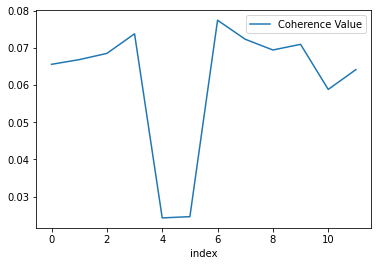

In [ ]:
test_df_c_npmi=coherence_df[coherence_df['Coherence Type']=='c_npmi'].reset_index(drop=True)
test_df_c_npmi.reset_index(drop=False,inplace=True)
test_df_c_npmi.plot(x='index',y='Coherence Value')
test_df_c_npmi[test_df_c_npmi['Coherence Value']==test_df_c_npmi['Coherence Value'].max()]

# **Plotting for C_UCI**

,index,Combination,Coherence Type,Coherence Value
6,6,Perc90Topics20,c_uci,0.69337


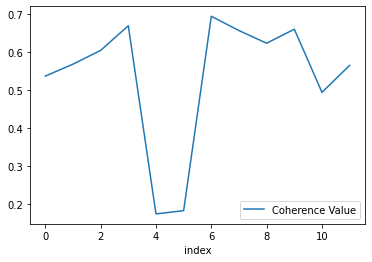

In [ ]:
test_df_c_uci=coherence_df[coherence_df['Coherence Type']=='c_uci'].reset_index(drop=True)
test_df_c_uci.reset_index(drop=False,inplace=True)
test_df_c_uci.plot(x='index',y='Coherence Value')
test_df_c_uci[test_df_c_uci['Coherence Value']==test_df_c_uci['Coherence Value'].max()]

# **Plotting for U_MASS**

,index,Combination,Coherence Type,Coherence Value
4,4,Perc90Topics10,u_mass,-0.449078


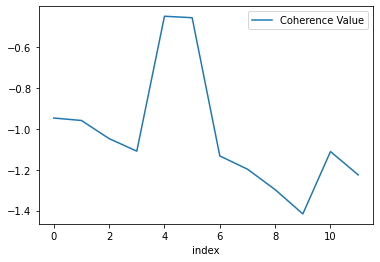

In [ ]:
test_df_u_mass=coherence_df[coherence_df['Coherence Type']=='u_mass'].reset_index(drop=True)
test_df_u_mass.reset_index(drop=False,inplace=True)
test_df_u_mass.plot(x='index',y='Coherence Value')
test_df_u_mass[test_df_u_mass['Coherence Value']==test_df_u_mass['Coherence Value'].max()]

# **Seeing which combination consistently performed well on the respective coherence measures**

In [ ]:
final_test_df=pd.DataFrame(columns=['index','Combination','Coherence Type','Coherence Value'])
final_test_df=pd.concat([final_test_df,
                         test_df_u_mass[test_df_u_mass['Coherence Value']==test_df_u_mass['Coherence Value'].max()],
                         test_df_c_uci[test_df_c_uci['Coherence Value']==test_df_c_uci['Coherence Value'].max()],
                         test_df_c_npmi[test_df_c_npmi['Coherence Value']==test_df_c_npmi['Coherence Value'].max()],
                         test_df_cv[test_df_cv['Coherence Value']==test_df_cv['Coherence Value'].max()]])
final_test_df.reset_index(drop=True,inplace=True)
final_test_df.drop(columns=['index'],inplace=True)
final_test_df

,Combination,Coherence Type,Coherence Value
0,Perc90Topics10,u_mass,-0.449078
1,Perc90Topics20,c_uci,0.693370
2,Perc90Topics20,c_npmi,0.077477
3,Perc90Topics20,c_v,0.588880


## **From the above table we can see that the coombination Perc90Topics20 yielded the best results**

## **The topics yielded by the model Perc90Topics20 are**

In [ ]:
with open(dir_components['Perc90Topics20'][1],'r') as f:
  for line in f.readlines():
    print(line)

0	0.08027	flow equation solution field function velocity variance head transport case cid coefficient dispersion problem element domain matrix approximation conductivity direction 

1	0.04424	fracture particle transport ﬂow permeability test experiment velocity pressure injection simulation porosity image point rock cell domain diffusion scale heterogeneity 

2	0.06214	flood distribution level probability variable ﬂood cluster variance event correlation series frequency estimator estimation duration threshold process moment curve statistic 

3	0.05066	concentration rate transport source reaction stream adsorption mix column load solute sediment sorption nitrogen equilibrium nutrient doc ion tracer chloride 

4	0.04246	cost optimization design solution system constraint problem ascelibrary_org york_university download rights_reserve scenario management uncertainty fig pump plan objective objective_function reliability 

5	0.02655	concentration exposure specie chemical risk sediment asse

In [ ]:
with open(dir_components['Perc90Topics20'][0],'rb') as f:
  model=pickle.load(f)
pprint(model.print_topics(num_topics=20, num_words=10))

[(0,
  '0.141*"flow" + 0.068*"equation" + 0.032*"solution" + 0.029*"field" + '
  '0.016*"function" + 0.013*"velocity" + 0.013*"variance" + 0.012*"head" + '
  '0.011*"transport" + 0.010*"case"'),
 (1,
  '0.053*"fracture" + 0.034*"particle" + 0.030*"transport" + 0.029*"ﬂow" + '
  '0.023*"permeability" + 0.022*"test" + 0.020*"experiment" + 0.018*"velocity" '
  '+ 0.015*"pressure" + 0.015*"injection"'),
 (2,
  '0.051*"flood" + 0.048*"distribution" + 0.042*"level" + 0.027*"probability" '
  '+ 0.019*"variable" + 0.017*"ﬂood" + 0.017*"cluster" + 0.013*"variance" + '
  '0.012*"event" + 0.012*"correlation"'),
 (3,
  '0.135*"concentration" + 0.039*"rate" + 0.030*"transport" + 0.029*"source" + '
  '0.019*"reaction" + 0.017*"stream" + 0.015*"adsorption" + 0.014*"mix" + '
  '0.014*"column" + 0.013*"load"'),
 (4,
  '0.063*"cost" + 0.042*"optimization" + 0.041*"design" + 0.037*"solution" + '
  '0.037*"system" + 0.026*"constraint" + 0.024*"problem" + '
  '0.022*"ascelibrary_org" + 0.022*"york_universi